In [3]:
from scipy.stats import laplace
import matplotlib.pyplot as plt
import pandas as pd

## Importa o dataset

In [38]:
dataset = pd.read_csv("adult.csv")
dataset.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class
0,2,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States,<=50K
1,3,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States,<=50K
2,2,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States,<=50K
3,3,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States,<=50K
4,1,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba,<=50K


## Consultas
1. Q1: Média do atributo age
2. Q2: Somatório do atributo capital-gain;
3. Q3: Média do atributo hours-per-week ;
4. Q4: Quantidade de pessoas com income > 50K.

In [39]:
def Q1(dataset):
    return dataset.age.mean()

def Q2(dataset):
    return dataset.capitalgain.sum()

def Q3(dataset):
    return dataset.hoursperweek.mean()

def Q4(dataset):
    DatasetProcessado = dataset[dataset["class"] == ">50K"]
    return DatasetProcessado.shape[0]


## Vizinhaça


In [40]:
def gerarVizinho(dataset,linhaRemover):
    return dataset.drop([linhaRemover])

def gerarListaVizinhosOtimizado(dataset, f):
    naoMudar = NaoMudar(f)
    unicos = []
    listaTodosVizinhos = []
    for i in range(dataset.shape[0]):
        if(dataset.iloc[i][naoMudar] not in unicos):
            unicos.append(dataset.iloc[i][naoMudar])
            listaTodosVizinhos.append(gerarVizinho(dataset, i))
    return listaTodosVizinhos

In [41]:
def NaoMudar(f):
    if(f==Q1):
        return "age"
    if(f==Q2):
        return "capitalgain"
    if(f==Q3):
        return "hoursperweek"
    if(f==Q4):
        return "capitalgain"
    if(f==f1):
        return "casas"

## Sensibilidade

In [42]:
def deltaF(dataset, f):   
    sensibilidadeDatasetOriginal = f(dataset)
    maiorDiferenca = 0
        
    for vizinho in gerarListaVizinhosOtimizado(dataset, f):
        diferenca = abs(sensibilidadeDatasetOriginal - f(vizinho))
        if maiorDiferenca < diferenca:
            maiorDiferenca = diferenca
            
    return maiorDiferenca

## Laplace

In [43]:
def LAP(delta, budget, u):
    ApresentarDistribuicao(u, (delta/budget))
    return laplace.rvs(loc=u, scale=(delta/budget))

## Apresenta Laplace

In [44]:
def ApresentarDistribuicao(l, s):
    fig, ax = plt.subplots(1, 1)
    r = laplace.rvs(loc=l, scale=s, size=1000)
    ax.hist(r, density=True)
    plt.show()

## Mecanismo

In [45]:
def Ml(dataset, funcoes, budgets, u):
    resultados = []
    for budget in budgets:
        for funcao in funcoes:     
            delta = deltaF(dataset, funcao)
            print("delta = " + str(delta))
            
            lap = LAP(delta, budget, u)
            print("laplace = " + str(lap))
            
            resultado = funcao(dataset) + lap
            print("e: {}, result:{}, delta: {}".format(budget, resultado, delta))
            
            resultados.append(resultado)
            
    return resultados

delta = 4.5636285693984036e-05


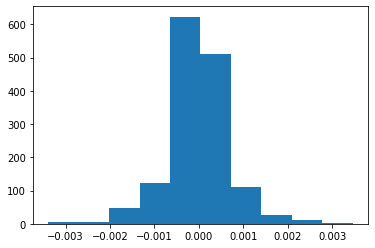

laplace = 0.0010408760857418668
e: 0.1, result:1.7721190465128334, delta: 4.5636285693984036e-05
delta = 4


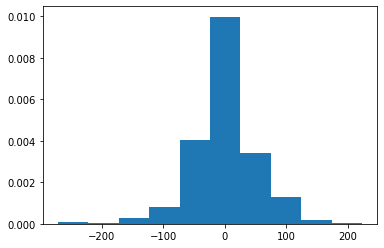

laplace = -8.423094738143714
e: 0.1, result:9775.576905261856, delta: 4
delta = 4.19586378328507e-05


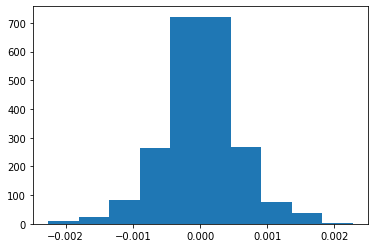

laplace = -6.325018976610751e-06
e: 0.1, result:1.9506918445891477, delta: 4.19586378328507e-05
delta = 1


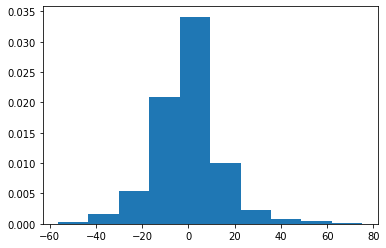

laplace = -11.819897347048672
e: 0.1, result:11675.180102652952, delta: 1
delta = 4.5636285693984036e-05


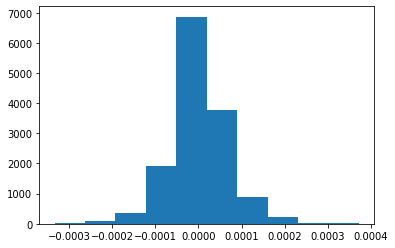

laplace = 6.849423535550714e-05
e: 1, result:1.771146664662447, delta: 4.5636285693984036e-05
delta = 4


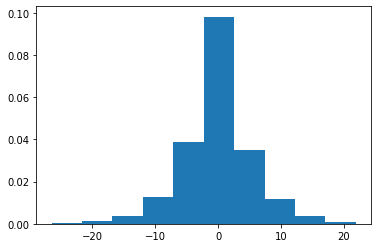

laplace = -1.3874698998427755
e: 1, result:9782.612530100158, delta: 4
delta = 4.19586378328507e-05


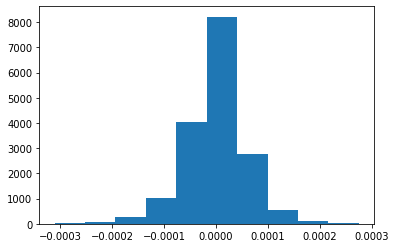

laplace = 2.19188005086264e-05
e: 1, result:1.9507200884086329, delta: 4.19586378328507e-05
delta = 1


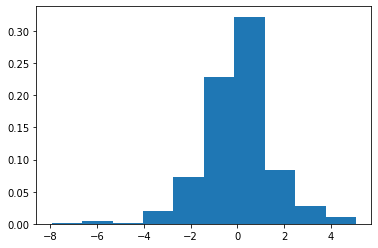

laplace = -0.01444783203246066
e: 1, result:11686.985552167967, delta: 1
delta = 4.5636285693984036e-05


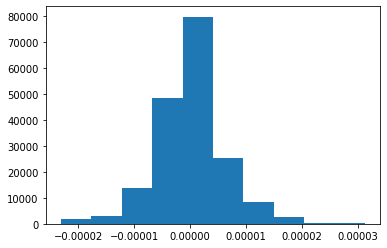

laplace = -1.1249438789343675e-07
e: 10, result:1.7710780579327037, delta: 4.5636285693984036e-05
delta = 4


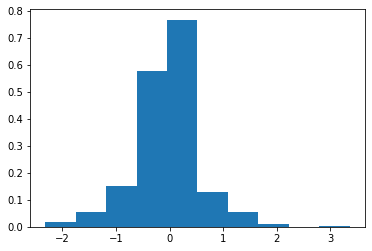

laplace = 1.0640800803133466
e: 10, result:9785.064080080314, delta: 4
delta = 4.19586378328507e-05


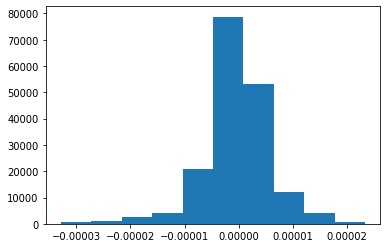

laplace = 1.590494830791433e-08
e: 10, result:1.9506981855130725, delta: 4.19586378328507e-05
delta = 1


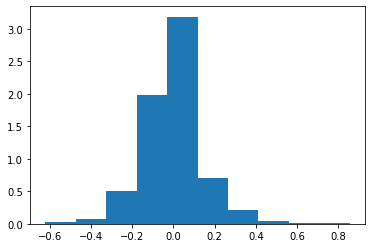

laplace = 0.21817825071671174
e: 10, result:11687.218178250716, delta: 1


[1.7721190465128334,
 9775.576905261856,
 1.9506918445891477,
 11675.180102652952,
 1.771146664662447,
 9782.612530100158,
 1.9507200884086329,
 11686.985552167967,
 1.7710780579327037,
 9785.064080080314,
 1.9506981855130725,
 11687.218178250716]

In [46]:
budgets = [0.1, 1, 10]
funcoes = [Q1, Q2, Q3, Q4]
u = 0
Ml(dataset, funcoes, budgets, u)

## Salvando o resultado

In [ ]:
result = open("result.csv",'w')

delta = 4.5636285693984036e-05


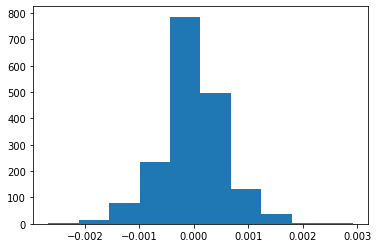

laplace = -0.00010428880749995656
e: 0.1, result:1.7709738816195915, delta: 4.5636285693984036e-05


delta = 4.5636285693984036e-05


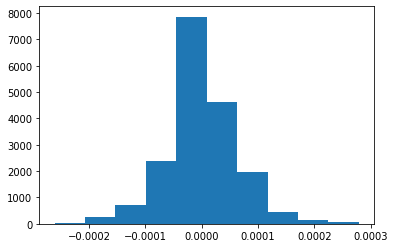

laplace = 3.680114517622658e-05
e: 1, result:1.7711149715722676, delta: 4.5636285693984036e-05


delta = 4.5636285693984036e-05


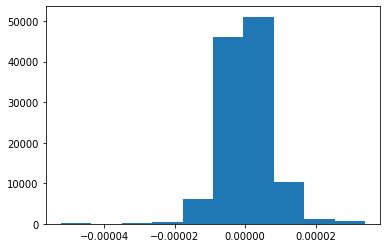

laplace = 3.975002941545984e-06
e: 10, result:1.771082145430033, delta: 4.5636285693984036e-05




In [0]:
listaFuncoes = [Q1,Q2,Q3,Q4]
for i in e:
  for j in [Q1]:#listaFuncoes:
      Ml(dataset, j,i)
      print("\n")

In [0]:
Q1(dataset)

1.7710781704270915

In [20]:
#exemplo do slide
d = {'nome': ["z", "s","g","l"], 'casas': [4,2,7,1]}
df = pd.DataFrame(data=d)

In [21]:
def f1(dataset):
    return dataset.casas.sum()

14
14
14
14
delta = 7


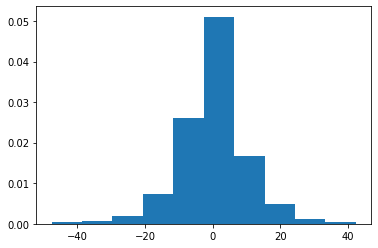

laplace = 3.420204421761602
e: 1, result:17.420204421761603, delta: 7


17.420204421761603

In [0]:
Ml(df, f1)

In [0]:
result.close()

In [28]:
Ml(df, [f1], [1], 0)

delta = 7
laplace = -0.7762462645097326
e: 1, result:13.223753735490268, delta: 7


13.223753735490268